### Analyse de Portefeuille: Mesures de Performances

Ce script est conçu pour évaluer la performance d'un portefeuille d'investissement en le comparant à un benchmark (indice de référence). Pour cela, nous allons télécharger des données historiques, calculer des métriques de performance clés telles que le ratio de Sharpe, le ratio de Treynor, l'alpha de Jensen et le ratio d'information, puis visualiser les performances du portefeuille par rapport au benchmark.

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from IPython.display import display, HTML

# Configurer le style des graphiques
plt.style.use('fast')

--- 

### I — Récupération et Traitement des Données

Dans cette section, nous téléchargeons les prix de clôture ajustés des actifs et calculons les rendements du portefeuille. La fonction `GetMarketData` télécharge les données historiques via yfinance et `PortfolioReturns` calcule les rendements pondérés.

In [87]:
def GetMarketData(Tickers, StartDate, EndDate):
    # Télécharger les données de clôture ajustée pour les tickers spécifiés
    Data = yf.download(Tickers, start=StartDate, end=EndDate, progress=False)['Adj Close']
    if Data.empty:
        raise ValueError(f"Aucune donnée trouvée pour {Tickers} de {StartDate} à {EndDate}.")
    
    # Filtrer les jours non ouvrables (week-ends)
    Data = Data[Data.index.dayofweek < 5]
    return Data

def PortfolioReturns(Prices, Weights):
    # Calculer les rendements quotidiens
    Returns = Prices.pct_change().dropna()
    # Appliquer les poids et sommer les rendements pondérés
    PortfolioRet = (Returns * Weights).sum(axis=1)
    return PortfolioRet

--- 

### II — Fonctions pour Calculer les Métriques de Performance

Dans cette section, nous définissons les fonctions qui calculent les métriques de performance. Elles sont essentielles pour évaluer le rendement et le risque du portefeuille par rapport au benchmark.

---
**1. Ratio de Sharpe**

Le ratio de Sharpe mesure la rentabilité ajustée au risque du portefeuille. Plus le ratio de Sharpe est élevé, meilleure est la performance du portefeuille par rapport au risque pris.  

$$\text{Sharpe Ratio} = \frac{E[R_p] - R_f}{\sigma_p}$$

Où :

- $ E[R_p] $ est le rendement moyen du portefeuille.
- $ R_f $ est le taux sans risque.
- $ \sigma_p $ est l'écart-type des rendements du portefeuille.

In [88]:
def SharpeRatio(Returns, RiskFreeRate=0.03):
    # Calculer le ratio de Sharpe annualisé
    ExcessReturn = Returns.mean() * 252 - RiskFreeRate
    Sharpe = ExcessReturn / (Returns.std() * np.sqrt(252))
    return Sharpe

---

**2. Ratio de Treynor**

Le ratio de Treynor évalue la rentabilité par unité de risque systématique (risque non diversifiable). Un ratio de Treynor plus élevé indique une meilleure performance par unité de risque systématique.

$$\text{Treynor Ratio} = \frac{E[R_p] - R_f}{\beta_p}$$

Où :

- $ \beta_p $ est la sensibilité du portefeuille aux mouvements du marché (bêta).

In [89]:
def TreynorRatio(Returns, BenchmarkReturns, RiskFreeRate=0.03):
    # Calculer le ratio de Treynor
    Beta = CalculateBeta(Returns, BenchmarkReturns)
    ExcessReturn = Returns.mean() * 252 - RiskFreeRate
    Treynor = ExcessReturn / Beta
    return Treynor

---

**3. Alpha de Jensen**

L'alpha de Jensen mesure la performance du portefeuille par rapport à celle attendue selon le modèle CAPM. Un alpha positif indique que le portefeuille a surperformé les attentes du modèle CAPM.


$$\alpha_p = E[R_p] - \left( R_f + \beta_p (E[R_m] - R_f) \right)$$

Où :

- $ E[R_m] $ est le rendement moyen du marché (benchmark).

In [90]:
def JensensAlpha(Returns, BenchmarkReturns, RiskFreeRate=0.03):
    # Calculer l'alpha de Jensen
    Beta = CalculateBeta(Returns, BenchmarkReturns)
    ExpectedReturn = RiskFreeRate + Beta * (BenchmarkReturns.mean() * 252 - RiskFreeRate)
    Alpha = Returns.mean() * 252 - ExpectedReturn
    return Alpha

---

**4. Ratio d'Information**

Le ratio d'information mesure la capacité du portefeuille à générer un rendement excédentaire par rapport au benchmark, ajusté pour la volatilité de cet excédent. Un ratio d'information plus élevé indique une meilleure performance ajustée pour le risque de l'excédent de rendement.

$$\text{Information Ratio} = \frac{E[R_p - R_b]}{\sigma(R_p - R_b)}$$

Où :

- $ R_b $ est le rendement du benchmark.

In [91]:
def InformationRatio(Returns, BenchmarkReturns):
    # Calculer le ratio d'information
    ActiveReturn = Returns - BenchmarkReturns
    TrackingError = ActiveReturn.std() * np.sqrt(252)
    Information = (ActiveReturn.mean() * 252) / TrackingError
    return Information

---

**5. Bêta**

Le bêta mesure la sensibilité du portefeuille aux mouvements du marché. Un bêta supérieur à 1 indique que le portefeuille est plus volatil que le marché.

$$\beta_p = \frac{\text{Cov}(R_p, R_m)}{\text{Var}(R_m)}$$


In [92]:
def CalculateBeta(Returns, BenchmarkReturns):
    # Calculer le bêta du portefeuille par rapport au benchmark
    Covariance = Returns.cov(BenchmarkReturns)
    Variance = BenchmarkReturns.var()
    Beta = Covariance / Variance
    return Beta

---

**6. Meilleure et Pire Année**

Cette métrique identifie les années de meilleure et pire performance du portefeuille.

In [93]:
def BestWorstYear(Returns):
    # Identifier la meilleure et la pire année en termes de rendement
    YearlyReturns = Returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
    BestYear = YearlyReturns.max() * 100
    WorstYear = YearlyReturns.min() * 100
    return BestYear, WorstYear

----

**7. Maximum Drawdown**

Le maximum drawdown mesure la plus grande perte de valeur cumulative par rapport à un pic précédent, indiquant le risque de baisse maximal du portefeuille.

$$\text{Max Drawdown} = \min \left( \frac{C_t - P_t}{C_t} \right)$$

Où :

- $ C_t $ est la valeur cumulative maximale jusqu'à la période $ t $.
- $ P_t $ est la valeur cumulative à la période $ t $.

In [94]:
def MaxDrawdown(Returns):
    # Calculer le drawdown maximum
    CumulativeReturns = (1 + Returns).cumprod()
    Peak = CumulativeReturns.expanding(min_periods=1).max()
    Drawdown = (CumulativeReturns - Peak) / Peak
    MaxDD = Drawdown.min() * 100
    return MaxDD

---

### III — Fonction Principale pour le Calcul des Performances

Dans cette section, nous définissons la fonction principale qui calcule un résumé des performances du portefeuille par rapport au benchmark en utilisant les métriques précédemment définies.

La fonction `CalculatePerformanceSummary` télécharge les prix des actifs du portefeuille et du benchmark sur la période spécifiée, calcule les rendements quotidiens et détermine le rendement total sur la période pour chacun d'eux.

Elle calcule ensuite leurs taux de croissance annuel composé (ou CAGR pour Compound Annual Growth Rate) respectifs, qui fournissent une mesure annualisée de la croissance des investissements et est calculé tel que:

$$\text{CAGR} = \left(1 + \text{Rendement Cumulé}\right)^{\frac{252}{\text{Nombre de Jours de Trading}}} - 1$$
   
Elle utilise ensuite les fonctions définies dans les cellules précédentes pour calculer les métriques de performance et stocke les résultats dans un dictionnaire pour faciliter l'affichage par la suite.

In [95]:
def CalculatePerformanceSummary(Tickers, Weights, StartDate, EndDate, RiskFreeRate, InitialCapital, Benchmark):
    
    # Récupérer les données de marché pour les tickers et le benchmark
    Prices = GetMarketData(Tickers + [Benchmark], StartDate, EndDate)
    
    # Séparer les prix du portefeuille et du benchmark
    PortfolioPrices = Prices[Tickers]
    BenchmarkPrices = Prices[Benchmark]
    
    # Calculer la valeur du portefeuille
    PortfolioValues = (PortfolioPrices * Weights).sum(axis=1)
    
    # Calculer les rendements du portefeuille et du benchmark
    PortfolioRet = PortfolioReturns(PortfolioPrices, Weights)
    BenchmarkRet = BenchmarkPrices.pct_change().dropna()
    
    # Calculer le rendement cumulé
    PortfolioCumReturn = (PortfolioValues.iloc[-1] / PortfolioValues.iloc[0]) - 1
    BenchmarkCumReturn = (BenchmarkPrices.iloc[-1] / BenchmarkPrices.iloc[0]) - 1
    
    # Calculer le CAGR (taux de croissance annuel composé)
    TradingDays = len(PortfolioRet)
    PortfolioCAGR = (1 + PortfolioCumReturn) ** (252 / TradingDays) - 1
    BenchmarkCAGR = (1 + BenchmarkCumReturn) ** (252 / TradingDays) - 1
    
    # Calculer les différentes métriques de performance
    Metrics = {
        'Solde initial': [f"${InitialCapital:,.2f}", f"${InitialCapital:,.2f}"],
        'Solde final': [f"${InitialCapital * (1 + PortfolioCumReturn):,.2f}",
                        f"${InitialCapital * (1 + BenchmarkCumReturn):,.2f}"],
        'Rendement cumulatif (%)': [PortfolioCumReturn * 100, BenchmarkCumReturn * 100],
        'Rendement annualisé (CAGR %)': [PortfolioCAGR * 100, BenchmarkCAGR * 100],
        'Écart-type (%)': [PortfolioRet.std() * np.sqrt(252) * 100, BenchmarkRet.std() * np.sqrt(252) * 100],
        'Meilleure année (%)': [BestWorstYear(PortfolioRet)[0], BestWorstYear(BenchmarkRet)[0]],
        'Pire année (%)': [BestWorstYear(PortfolioRet)[1], BestWorstYear(BenchmarkRet)[1]],
        'Maximum Drawdown (%)': [MaxDrawdown(PortfolioRet), MaxDrawdown(BenchmarkRet)],
        'Ratio de Sharpe': [SharpeRatio(PortfolioRet, RiskFreeRate),
                             SharpeRatio(BenchmarkRet, RiskFreeRate)],
        'Ratio de Treynor': [TreynorRatio(PortfolioRet, BenchmarkRet, RiskFreeRate), 'N/A'],
        'Alpha de Jensen': [JensensAlpha(PortfolioRet, BenchmarkRet, RiskFreeRate), 'N/A'],
        'Ratio d\'information': [InformationRatio(PortfolioRet, BenchmarkRet), 'N/A'],
        'Corrélation avec le Benchmark': [PortfolioRet.corr(BenchmarkRet), '1.00']
    }
    return Metrics, PortfolioRet, BenchmarkRet

--- 

### IV — Fonctions d'Affichage et de Visualisation

Dans cette section, nous définissons les fonctions qui permettent de présenter les résultats de l'analyse. La fonction `DisplaySummaryTable` Génère un tableau HTML affichant les différentes métriques de performance pour le portefeuille et le benchmark, et la fonction`PlotPerformance` trace les courbes des performances cumulées du portefeuille et du benchmark pour permettre une comparaison visuelle.


$$\text{Valeur Cumulative} = \prod_{t=1}^{T} (1 + R(t))$$

Où :

- $ R(t) $ est le rendement à la date $ t $.

In [96]:
def DisplaySummaryTable(Summary):
    # Générer le contenu HTML pour le tableau des métriques
    HtmlContent = """
    <h3 style='text-align:center;'>Résumé des Performances</h3>
    <div style='display: flex; justify-content: center; margin: 20px;'>
        <table style='border-collapse: collapse; width: 80%;'>
            <thead>
                <tr style='background-color:#f2f2f2;'>
                    <th style='padding: 8px; border: 1px solid #ddd;'>Métrique</th>
                    <th style='padding: 8px; border: 1px solid #ddd;'>Portefeuille</th>
                    <th style='padding: 8px; border: 1px solid #ddd;'>Benchmark</th>
                </tr>
            </thead>
            <tbody>
    """
    # Ajouter les lignes du tableau
    for Key, Value in Summary.items():
        # Formater les valeurs en pourcentage si nécessaire
        PortfolioValue = f"{Value[0]:.2f}%" if isinstance(Value[0], (int, float)) else Value[0]
        BenchmarkValue = f"{Value[1]:.2f}%" if isinstance(Value[1], (int, float)) else Value[1]
        HtmlContent += f"""
        <tr>
            <td style='padding: 8px; border: 1px solid #ddd;'>{Key}</td>
            <td style='padding: 8px; border: 1px solid #ddd;'>{PortfolioValue}</td>
            <td style='padding: 8px; border: 1px solid #ddd;'>{BenchmarkValue}</td>
        </tr>
        """
    # Fermer les balises HTML
    HtmlContent += "</tbody></table></div>"
    # Afficher le contenu HTML
    display(HTML(HtmlContent))

def PlotPerformance(PortfolioReturns, BenchmarkReturns=None):
    # Créer une figure pour le graphique
    plt.figure(figsize=(14, 7))
    
    # Tracer la performance cumulée du portefeuille
    plt.plot((1 + PortfolioReturns).cumprod(), label='Portefeuille')
    
    # Tracer la performance cumulée du benchmark si disponible
    if BenchmarkReturns is not None:
        plt.plot((1 + BenchmarkReturns).cumprod(), label='Benchmark')
    
    # Configurer les labels et le titre
    plt.xlabel('Date')
    plt.ylabel('Valeur Cumulative')
    plt.legend()
    plt.title("Performance du Portefeuille vs Benchmark")
    
    # Afficher le graphique
    plt.show()

---

### V — Fonction d'Analyse du Portefeuille

Dans cette section, nous définissons la fonction qui effectue l'analyse complète du portefeuille : les poids des actifs sont normalisés pour s'assurer que leur somme est égale à 1. Ensuite, on  utilise `CalculatePerformanceSummary` pour obtenir les métriques, les rendements du portefeuille et ceux du benchmark, puis on affiche le résumé des performances sous forme de tableau et on trace les performances cumulées du portefeuille et du benchmark.

In [97]:
def AnalyzePortfolio(Tickers, Weights, StartDate, EndDate, RiskFreeRate, InitialCapital, Benchmark):
    # Convertir les poids en array NumPy et les normaliser
    Weights = np.array(Weights)
    Weights /= Weights.sum()  # Normaliser les poids
    
    # Calculer le résumé des performances
    Summary, PortfolioRet, BenchmarkRet = CalculatePerformanceSummary(
        Tickers, Weights, StartDate, EndDate, RiskFreeRate, InitialCapital, Benchmark
    )
    
    # Afficher le résumé sous forme de tableau
    DisplaySummaryTable(Summary)
    
    # Tracer les performances cumulées
    PlotPerformance(PortfolioRet, BenchmarkRet)

Métrique,Portefeuille,Benchmark
Solde initial,"$100,000.00","$100,000.00"
Solde final,"$143,948.96","$123,325.81"
Rendement cumulatif (%),43.95%,23.33%
Rendement annualisé (CAGR %),12.59%,7.06%
Écart-type (%),33.32%,25.28%
Meilleure année (%),61.67%,26.89%
Pire année (%),-36.31%,-19.44%
Maximum Drawdown (%),-40.48%,-33.92%
Ratio de Sharpe,0.44%,0.28%
Ratio de Treynor,0.13%,N/A


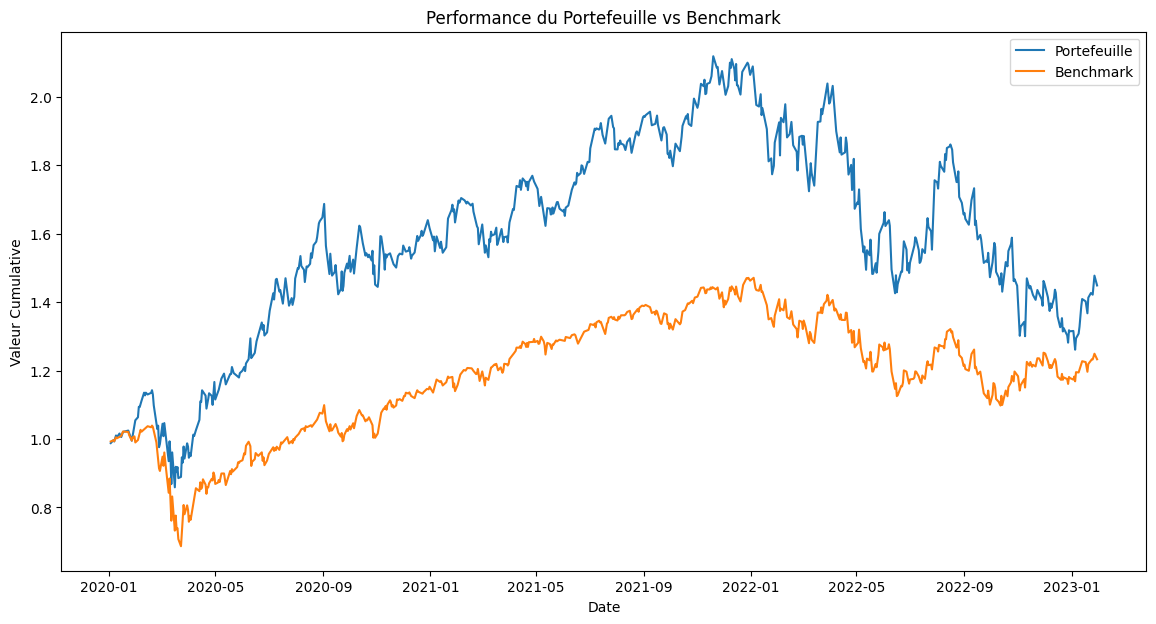

In [98]:
#Exemple d'utilisation
# Définir les paramètres du portefeuille
Tickers = ['AMZN', 'MSFT', 'AAPL']
Weights = [0.4, 0.4, 0.2]
StartDate = '2020-01-01'#YYYY-MM-DD
EndDate = '2023-01-31'#YYYY-MM-DD
RiskFreeRate = 0.03
InitialCapital = 100000
Benchmark = '^GSPC'  # S&P 500

# Exécuter l'analyse du portefeuille
AnalyzePortfolio(Tickers, Weights, StartDate, EndDate, RiskFreeRate, InitialCapital, Benchmark)